# Aanlysis of Cracow housing offers prices, 03.2019

data downloaded with: 
    
https://ofedoruk.pl/szukamy-mieszkania-za-pomoca-pythona-i-beautiful-soup/,  


# Linear Regression Analysis

Target variable: housing price (PLN per square meter)
    
explanatory variables:
    -housing area
    -number of rooms
    
    variables extracted from map, base on offers locations
    -distance to roads
    -distance to the city center
    -distance to park and forests
    -distance to tram stops

In [44]:
#-*- coding: windows-1250 -*-
import os
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import geopandas as gp

In [45]:
def czyszczenie(df, ALL_NUMERIC_COLUMNS, NUMERIC_COLUMNS):
    
    df = df.rename(columns={'il_pok': 'no_rooms', 'Powierzchn': 'flat_area',
                            'trams': 'dst_tram', 'centre': 'dst_centre',
                            'parks': 'dst_parks', 'vistula': 'dst_riv', 
                             'cena_za_me': 'price'})
    
    #usuniecie zbednych znakow - podmienic kod na uniwersalny - oparty o liste kolumn
    df[ALL_NUMERIC_COLUMNS]= df[ALL_NUMERIC_COLUMNS].replace(['>',' ', '/', 'pokoje',
                 'pokój', 'pokoi', 'zł', 'm²'],'', regex=True)
    df[ALL_NUMERIC_COLUMNS]= df[ALL_NUMERIC_COLUMNS].replace(',','.', regex=True)
    df[ALL_NUMERIC_COLUMNS] = df[ALL_NUMERIC_COLUMNS].astype(float)
    
    # outliery z common sense
    df = df.loc[df['price'] < 15000]
    df = df.loc[df['price'] > 3000]
    
    df = df.drop_duplicates(NUMERIC_COLUMNS, keep='first')  #usuwanie duplikatow
     # df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].apply(lambda x: np.log(x))  ##normalizacja 
    return df

# Reading of data from Shapefiles and plottin them on a map

In [46]:
flats = gp.read_file(r'shp\flats.shp')
border = gp.read_file(r'shp\krk_border.shp')

import folium
from folium.plugins import HeatMap

max_amount = float(flats['cena_za_me'].max())

hmap = folium.Map(location=[50.05, 19.95], zoom_start=12, )

hm_wide = HeatMap(list(zip(flats.lat.values, flats.lon.values, flats.cena_za_me.values)),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=12, blur=20, 
                   max_zoom=1, 
                 )

hmap.add_child(hm_wide)

# data cleaning

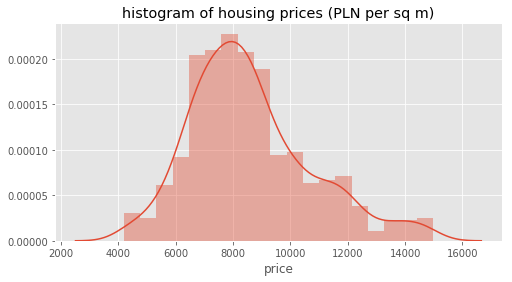

In [47]:
ALL_NUMERIC_COLUMNS= ['flat_area', 'no_rooms', 'dst_tram', 'dst_centre', 'price', 'dst_riv', 'dst_parks']
NUMERIC_COLUMNS_spatial =  ['flat_area', 'no_rooms', 'dst_tram', 'dst_centre', 'dst_parks','dst_riv']
NUMERIC_COLUMNS_non_spatial =  ['flat_area', 'no_rooms']

df = czyszczenie(flats, ALL_NUMERIC_COLUMNS, NUMERIC_COLUMNS)
plt.figure(figsize=(8,4))
_ = sns.distplot(df['price']).set_title('histogram of housing prices (PLN per sq m)')

plt.style.use('ggplot')
df3 = df.iloc[100:]
holdout_df =  df.iloc[:100]

# linear regression pipeline

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='mean', axis=0)),
         ('scaler', StandardScaler()),
        ('linreg', LinearRegression())]

# Create the pipeline: pipeline
pipeline_ns = Pipeline(steps)

# Split using ALL data in sample_df
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(df3[NUMERIC_COLUMNS_non_spatial],  
                                                    df3['price'])
# Fit it to the training data
pipeline_ns.fit(X_train_ns, y_train_ns)

# Compute and print the metrics
r2 = pipeline_ns.score(X_test_ns, y_test_ns)
display("R squared: {} with non spatial varialbles".format(r2))


# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'elasticnet__l1_ratio':np.linspace(0,1,30)}

# Split using ALL data in sample_df
X_train, X_test, y_train, y_test = train_test_split(df3[NUMERIC_COLUMNS_spatial],  
                                                    df3['price'])

# Fit it to the training data
pipeline.fit(X_train, y_train)

# Compute and print the metrics
r2 = pipeline.score(X_test, y_test)
display("R squared: {} with spatial variables".format(r2))

# wyprintowac coefficients
coef_df = DataFrame(zip(X_train.columns, np.transpose(pipeline.steps[2][1].coef_)))
coef_df.columns = ['variable', 'impact of max on price']

'R squared: 0.014900601633 with non spatial varialbles'

'R squared: 0.383032447554 with spatial variables'

# SHAP explanation of model features importance

In [61]:
# visualise the statistic modelling outputs with SHAP
import shap
shap.initjs()

explainer = shap.KernelExplainer(pipeline.predict, X_train, link="identity")
shap_values = explainer.shap_values(X_train)

shap.force_plot(explainer.expected_value, shap_values, X_train)

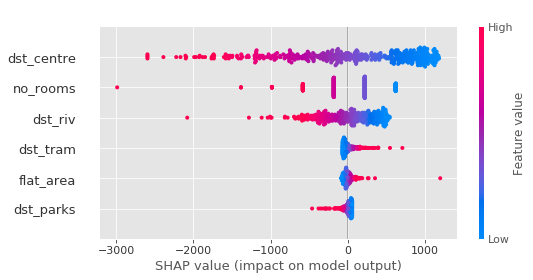

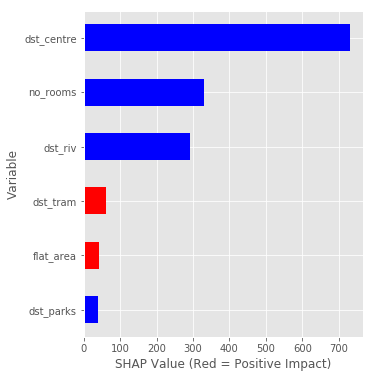

In [62]:
# visualise the statistic modelling outputs with SHAP
shap.summary_plot(shap_values, X_train)

def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values, X_train) 

# Housing offers prediction

In [63]:
# predykcja cen mieszkan na holdout dataset
holdout_df['price_pred'] = pipeline.predict(holdout_df[NUMERIC_COLUMNS])
# holdout_df = holdout_df.drop(['FolderPath', 'OBJECTID', 'geometry'], axis=1)
display(holdout_df.tail(5))
holdout_df.to_csv('prediction.csv')

,OBJECTID,FolderPath,Dzielnica,no_rooms,flat_area,x,price,dst_parks,dst_tram,dst_centre,dst_riv,lon,lat,geometry,price_pred
95,97,06_03_ajdi,Mistrzejowice,2.0,42.00,571669.0,8571.0,212.132,152.069,5912.12,3869.51,20.002287,50.093868,POINT Z (571668.858 247882.947 0.000),7394.660084
96,98,06_03_ajdi,WzgĂłrza KrzesĹ‚awickie,3.0,46.28,575814.0,7109.0,371.652,760.345,9852.95,5445.76,20.060421,50.101006,POINT Z (575814.388 248733.738 0.000),5137.654939
97,99,06_03_ajdi,Nowa Huta,2.0,40.80,575520.0,6029.0,75.000,460.977,9271.76,4728.24,20.056158,50.094688,POINT Z (575519.593 248027.231 0.000),5941.086838
98,100,06_03_ajdi,PrÄ…dnik Czerwony,2.0,55.00,570491.0,6273.0,223.607,1078.480,4599.59,3125.40,19.985702,50.088196,POINT Z (570491.311 247236.777 0.000),8232.252855
99,101,06_03_ajdi,Stara Krowodrza,2.0,49.00,565518.0,8551.0,388.909,1012.420,2947.14,3233.52,19.916047,50.082739,POINT Z (565517.541 246566.781 0.000),8791.403156
